In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [102]:
df_train=pd.read_csv('Google_Stock_Price_Train.csv')
df_train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [103]:
training_set=df_train.iloc[:,1:2].values # take all the rows of the column 'Open', and .values will change it to a numpy array
training_set.shape

(1258, 1)

# feature scaling 

In [7]:
# when build an RNN and use sigmoid as the activation function, it is recommended to use normalization
#  Xnorm = (X-min(X)/(max(X)-min(x)), where Xnorm will be between 0 and 1
# so we use MinMaxScaler library

In [84]:
from sklearn.preprocessing import MinMaxScaler

In [85]:
sc=MinMaxScaler()

In [104]:
training_set_sc = sc.fit_transform(training_set)# fit each value into the Xnorm formula and get the result

In [87]:
print (training_set.max())
print (training_set.min())
print(training_set[0])
print((325.25-279.12)/(816.68-279.12))

816.68
279.12
[ 325.25]
0.08581367661284321


In [88]:
# matched with the first value below

In [89]:
training_set_sc

array([[ 0.08581368],
       [ 0.09701243],
       [ 0.09433366],
       ..., 
       [ 0.95725128],
       [ 0.93796041],
       [ 0.93688146]])

In [90]:
# will use every 60 days' stock price to predict the next one. (3 months should be enough, later experiment other #)

In [91]:
training_set_sc[:,0]

array([ 0.08581368,  0.09701243,  0.09433366, ...,  0.95725128,
        0.93796041,  0.93688146])

In [105]:
x_train = []
y_train = []
for i in range(60,1258):
    x_train.append(training_set_sc[i-60:i,0]) # index 0 to 59.  (,0)='Open' column
    y_train.append(training_set_sc[i,0]) # i is excluded from above
# 0-59 to predict 60, then 1-60 to predict 61, and so on
# x_train[0]=60 rows, [1] also and so on
# y_train[0] = a single value

In [81]:
x_train[60][0] # every index has 60 rows. 

0.086278740977751345

In [77]:
y_train[0]

0.086278740977751345

In [106]:
# x_train and y_train are lists, neet to convert them into numpy arrays to be accepted by RNN
x_train, y_train=np.array(x_train), np.array(y_train)

In [98]:
print (x_train.shape) # 2d
print (y_train.shape) 

(1198, 60)
(1198,)


In [18]:
print(x_train.shape[0])

1198


In [107]:
# use the reshape function to add a dimension into a numpy array
# do this to x-train because it contains the input of the NN
# (x_train.shape[0],x_train.shape[1],1)=(batch size, time step,indictor)
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

In [100]:
print (x_train.shape) # 3d

(1198, 60, 1)


# Build the RNN

In [109]:
import keras
from keras.models import Sequential # allow us to create a neural network object representing a sequence of layers
from keras.layers import Dense # to add the output layer
from keras.layers import LSTM # add the lstm layer
from keras.layers import Dropout # to add some dropout regularlization(avoid over-fitting)

In [110]:
# initilizing the RNN
regressor = Sequential() # RNN is for regression

In [111]:
# add the 1st lstm layer with some droput regularization

# units=number of neuron in the each lstm layer 50 is large enough for a high dimesionality
# return_sequence = true means to add another layer after previous one. (stack lstm network)

# rate=percent of neuron need to drop out(.2*50=10). 10 neurons will be ignore durinbg the training that is in the 
# forward and back propagation happening in each iteration of the training

regressor.add(LSTM(units=50,return_sequences=True, input_shape = (x_train.shape[1],1)))
regressor.add(Dropout(rate=0.2))

In [112]:
x_train.shape[1],1

(60, 1)

In [113]:
# 2nd lstm layer with some droput regularization
regressor.add(LSTM(units=50,return_sequences=True))# only need the input shape in the begining (knows there are 50 neuron from the first layer)
regressor.add(Dropout(rate=0.2))

In [114]:
# 3rd lstm layer with some droput regularization
regressor.add(LSTM(units=50,return_sequences=True)) 
regressor.add(Dropout(rate=0.2))

In [115]:
# 4th lstm layer with some droput regularization
regressor.add(LSTM(units=50,return_sequences=False)) # dont need to return any more sequences
regressor.add(Dropout(rate=0.2))

In [116]:
# output layer
# use the dense function to make a fully connection
# units =1 because a specific stock price
regressor.add(Dense(units=1, ))

In [117]:
# compiling the RNN

# loss is not binary here because this is a regression problem.
regressor.compile(optimizer='adam', loss='mean_squared_error')

In [48]:
# fit the model to the training set

# 100 is better but 10 is ok just for practice. (dont want to kill my laptop too much)
# batch size : update the weights  every 32 times being forward probagation into the neural network then generating 
# an arror and then back propagation into the neural network
regressor.fit(x_train, y_train, batch_size=32, epochs=100)

#32/1198 then 64/1198 and so on

# x_train = data for stock price. y train is the stock price after every 60 price in x train
# 60 stock price to predict one

Epoch 1/100
1198/1198 [==============================] - 19s 16ms/step - loss: 0.0028
Epoch 2/100
1198/1198 [==============================] - 18s 15ms/step - loss: 0.0030
Epoch 3/100
1198/1198 [==============================] - 19s 16ms/step - loss: 0.0030
Epoch 4/100
1198/1198 [==============================] - 19s 16ms/step - loss: 0.0029
Epoch 5/100
1198/1198 [==============================] - 19s 16ms/step - loss: 0.0028
Epoch 6/100
1198/1198 [==============================] - 19s 16ms/step - loss: 0.0026
Epoch 7/100
1198/1198 [==============================] - 20s 17ms/step - loss: 0.0023
Epoch 8/100
1198/1198 [==============================] - 19s 16ms/step - loss: 0.0027
Epoch 9/100
1198/1198 [==============================] - 20s 16ms/step - loss: 0.0028
Epoch 10/100
1198/1198 [==============================] - 19s 16ms/step - loss: 0.0024
Epoch 11/100
1198/1198 [==============================] - 20s 17ms/step - loss: 0.0022
Epoch 12/100
1198/1198 [============================

# prediction

In [ ]:
# predict the price in 2017 and compare it to actual data
# if the data is in the same file, use train test split

In [33]:
df_test = pd.read_csv('Google_Stock_Price_Test.csv')
Real_stock_price = df_test.iloc[:,1:2].values

In [34]:
# combine the training set and the test set

# len(total_dataset)-len(df_test) = first day in jan of 2017
# -60 = need to 60 days stock price before 1st jan 2017

total_dataset = pd.concat((df_train['Open'], df_test['Open']),axis = 0 )
inputs = total_dataset[len(total_dataset)-len(df_test) - 60:].values # all price in 2017 and last 60 days in 2016

In [35]:
print (inputs)
print(df_test['Open'].tail())

[ 779.    779.66  777.71  786.66  783.76  781.22  781.65  779.8   787.85
  798.24  803.3   795.    804.9   816.68  806.34  801.    808.35  795.47
  782.89  778.2   767.25  750.66  774.5   783.4   779.94  791.17  756.54
  755.6   746.97  755.2   766.92  771.37  762.61  772.63  767.73  764.26
  760.    771.53  770.07  757.44  744.59  757.71  764.73  761.    772.48
  780.    785.04  793.9   797.4   797.34  800.4   790.22  796.76  795.84
  792.36  790.9   790.68  793.7   783.33  782.75  778.81  788.36  786.08
  795.26  806.4   807.86  805.    807.14  807.48  807.08  805.81  805.12
  806.91  807.25  822.3   829.62  837.81  834.71  814.66  796.86]
15    829.62
16    837.81
17    834.71
18    814.66
19    796.86
Name: Open, dtype: float64


In [36]:
inputs.shape # 1d

(80,)

In [ ]:
# the data need to be in 3d to fit into the model

In [37]:
inputs = inputs.reshape(-1,1)
inputs.shape # 2d

(80, 1)

In [38]:
inputs = sc.fit_transform(inputs)

In [39]:
x_test = []
for i in range (60,80):
    x_test.append(inputs[i-60:i,0]) # the first one: inputs[0:60,0] then 1:61
x_test=np.array(x_test)

In [40]:
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
x_test.shape # 3d

(20, 60, 1)

In [50]:
# now the data is ready to be used in the model
pred_stock_price = regressor.predict(x_test)
pred_stock_price.shape

(20, 1)

In [51]:
pred_stock_price = sc.inverse_transform(pred_stock_price) # reverse the transform data

In [52]:
pred_stock_price

array([[ 785.91369629],
       [ 782.50323486],
       [ 783.28930664],
       [ 785.50842285],
       [ 790.11181641],
       [ 798.32330322],
       [ 804.64367676],
       [ 805.35693359],
       [ 804.68322754],
       [ 804.59014893],
       [ 804.99621582],
       [ 805.05853271],
       [ 804.78778076],
       [ 805.37768555],
       [ 806.33917236],
       [ 813.58001709],
       [ 823.33483887],
       [ 831.59094238],
       [ 831.9465332 ],
       [ 821.3458252 ]], dtype=float32)

# visualization

In [ ]:
# epoches = 10

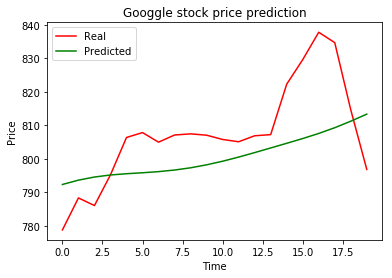

In [123]:
plt.plot(Real_stock_price,color='red', label='Real')
plt.plot(pred_stock_price,color='green',label='Predicted')
plt.title('Googgle stock price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

0.143296783923


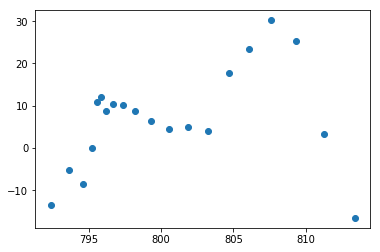

In [127]:
# R^2
from sklearn import metrics
print (metrics.r2_score(Real_stock_price, pred_stock_price))

# residual
plt.scatter(pred_stock_price,Real_stock_price-pred_stock_price)

In [ ]:
# R^2 is bad, and residual plot shows a pattern
# need to set a higher epoches

In [ ]:
# epoches = 30

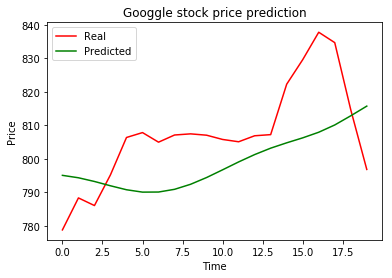

In [44]:
plt.plot(Real_stock_price,color='red', label='Real')
plt.plot(pred_stock_price,color='green',label='Predicted')
plt.title('Googgle stock price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

-0.0732959862594


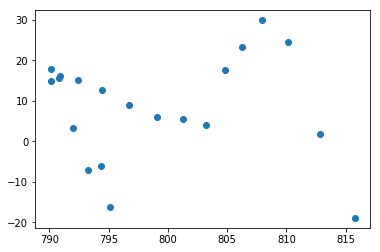

In [47]:
# R^2
from sklearn import metrics
print (metrics.r2_score(Real_stock_price, pred_stock_price))
# negative only when the chosen model does not follow the trend of the data

# residual
plt.scatter(pred_stock_price,Real_stock_price-pred_stock_price)

In [49]:
# 100 epoches

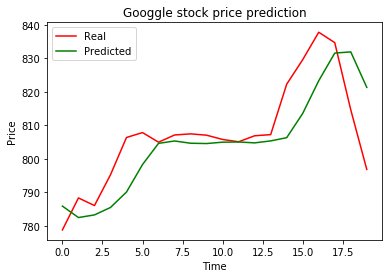

In [53]:
plt.plot(Real_stock_price,color='red', label='Real')
plt.plot(pred_stock_price,color='green',label='Predicted')
plt.title('Googgle stock price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

0.493978750115


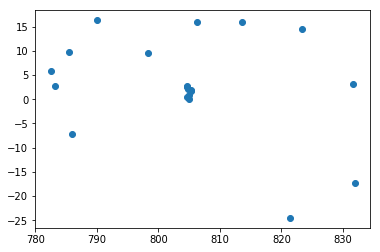

In [54]:
# R^2
from sklearn import metrics
print (metrics.r2_score(Real_stock_price, pred_stock_price))

# residual
plt.scatter(pred_stock_price,Real_stock_price-pred_stock_price)

In [ ]:
# better but still room to improve